#Mounting Google Drive for accessing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing Libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np 
from keras_preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import classification_report, confusion_matrix
import itertools 
import matplotlib.pyplot as plt


#Reading Train and Test Dataset from Drive

In [ ]:
train_dir = '/content/drive/MyDrive/Dogclass/train'
test_dir ='/content/drive/MyDrive/Dogclass/test'

#Reading CSV Files

In [ ]:
def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv(r"/content/drive/MyDrive/Dogclass/labels.csv",dtype=str)
testdf=pd.read_csv(r"/content/drive/MyDrive/Dogclass/sample_submission.csv",dtype=str)
traindf["id"]=traindf["id"].apply(append_ext)
testdf["id"]=testdf["id"].apply(append_ext)

#Including 11 Dog breeds

In [ ]:
included_breed = ['beagle', 'chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
'tibetan_mastiff']
for index,breed in traindf.iterrows():
    if breed[1] not in included_breed:
        traindf= traindf.drop([index])
traindf.shape

(841, 2)

In [ ]:
traindf.head()


,id,breed
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever
9,0042188c895a2f14ef64a918ed9c7b64.jpg,scottish_deerhound
20,008b1271ed1addaccf93783b39deab45.jpg,doberman
25,00a366d4b4a9bbb6c8a63126697b7656.jpg,golden_retriever
37,0100f55e4f0fe28f2c0465d3fc4b9897.jpg,golden_retriever


#Training Samples

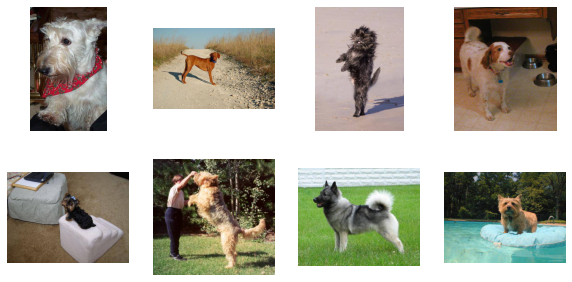

In [ ]:
import os 
src_path = "/content/drive/MyDrive/Dogclass/train"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

#DataGenerator

In [ ]:
train_datagen=ImageDataGenerator( rescale=1./255.,
                                  rotation_range = 20,
                                  brightness_range=[0.2,1.0],
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #zoom_range = [0.7,1],
                                  horizontal_flip = True,
                                  #Setting validation split to 2% 
                                  validation_split=0.1
                                  )

In [ ]:
BATCH_SIZE = 32
image_size=(224,224)


#Processing

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb" 
)

Found 757 validated image filenames belonging to 10 classes.


In [ ]:
valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb")

Found 84 validated image filenames belonging to 10 classes.


In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=test_dir,
x_col="id",
y_col=None,
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode=None,
target_size=image_size,
color_mode="rgb")

Found 10357 validated image filenames.


In [ ]:
shape=(224,224,3)
classes = len(included_breed)
classes

#ResNet50 Model

In [ ]:
pretrained_model = tf.keras.applications.ResNet50(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )
# pretrained_model.trainable = False
    
model = tf.keras.Sequential([ 
        pretrained_model,  
        tf.keras.layers.Flatten(),
#         tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(10, activation='softmax')
    ])

94773248/94765736 [==============================] - 1s 0us/step


#Calculating F1 Score,Precision,Recall


In [ ]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred): 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#Model Compilation

In [ ]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
opt=tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer= opt , loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

#Training Model

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,)
                   

Epoch 1/10
23/23 [==============================] - 16s 673ms/step - loss: 3.7218 - acc: 0.1959 - f1_m: 0.1721 - precision_m: 0.2236 - recall_m: 0.1414 - val_loss: 6.3316 - val_acc: 0.1406 - val_f1_m: 0.1406 - val_precision_m: 0.1406 - val_recall_m: 0.1406
Epoch 2/10
23/23 [==============================] - 15s 655ms/step - loss: 2.4234 - acc: 0.2828 - f1_m: 0.2338 - precision_m: 0.4871 - recall_m: 0.1604 - val_loss: 6.6469 - val_acc: 0.0781 - val_f1_m: 0.0781 - val_precision_m: 0.0781 - val_recall_m: 0.0781
Epoch 3/10
23/23 [==============================] - 15s 645ms/step - loss: 2.0561 - acc: 0.3972 - f1_m: 0.3409 - precision_m: 0.7044 - recall_m: 0.2312 - val_loss: 2.5652 - val_acc: 0.0938 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/10
23/23 [==============================] - 15s 649ms/step - loss: 1.7055 - acc: 0.4593 - f1_m: 0.4628 - precision_m: 0.6658 - recall_m: 0.3576 - val_loss: 3.1590 - val_acc: 0.1094 - val_f1_m: 0.0000e+00 - val

In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

#Accuracy Curve

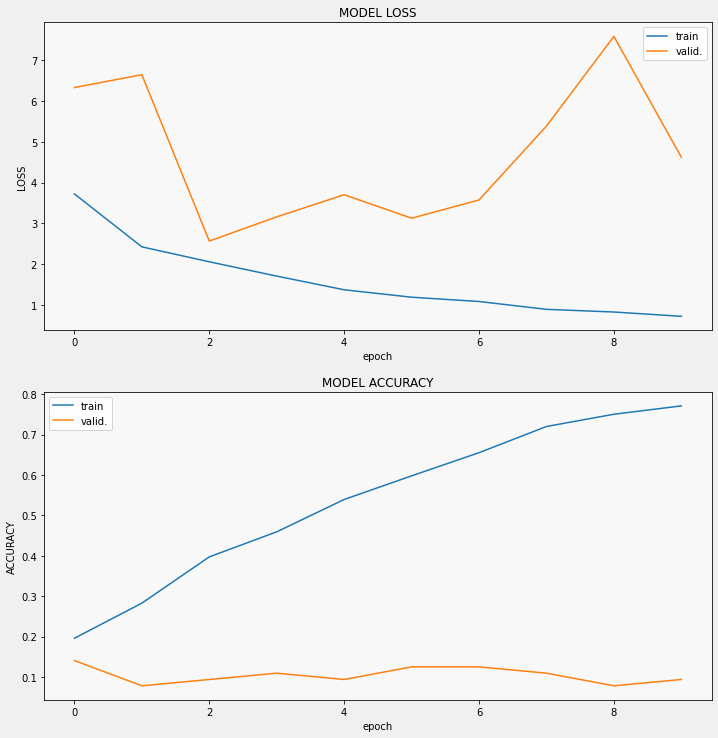

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'ACCURACY',
    212,
)

In [ ]:
loss, accuracy, f1_score, precision, recall = model.evaluate(valid_generator,batch_size=32)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

3/3 [==============================] - 2s 674ms/step - loss: 4.5781 - acc: 0.0952 - f1_m: 0.1021 - precision_m: 0.1021 - recall_m: 0.1021
Loss: 4.5781331062316895
Accuracy: 0.095238097012043
F1 Score: 0.10208327323198318


#Confusion Matrix

In [ ]:
Y_pred = model.predict(valid_generator,STEP_SIZE_VALID)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))

Confusion Matrix
[[ 8  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0]
 [ 9  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0]
 [ 8  0  0  0  0  0  0  0  0  0]
 [13  0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0]
 [15  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0]]


#classification Report

In [ ]:
print('Classification Report')
target_names = ['golden_retriever', 'malamute', 'pug','saint_bernard', 'scottish_deerhound','beagle', 'chihuahua', 'doberman','tibetan_mastiff','french_bulldog']
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Classification Report
                    precision    recall  f1-score   support

  golden_retriever       0.10      1.00      0.17         8
          malamute       0.00      0.00      0.00         8
               pug       0.00      0.00      0.00         9
     saint_bernard       0.00      0.00      0.00         3
scottish_deerhound       0.00      0.00      0.00         8
            beagle       0.00      0.00      0.00        13
         chihuahua       0.00      0.00      0.00        10
          doberman       0.00      0.00      0.00         5
   tibetan_mastiff       0.00      0.00      0.00        15
    french_bulldog       0.00      0.00      0.00         5

          accuracy                           0.10        84
         macro avg       0.01      0.10      0.02        84
      weighted avg       0.01      0.10      0.02        84



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Roc Curve

3/3 [==============================] - 1s 372ms/step


0.5

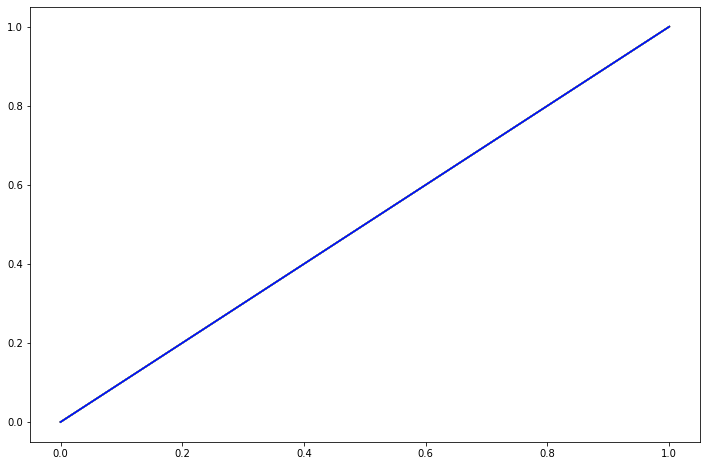

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score




fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
all_labels= ['beagle', 'chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
'tibetan_mastiff']

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels): # all_labels: no of the labels
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# calling
valid_generator.reset() # resetting generator
y_pred = model.predict(valid_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(valid_generator.classes, y_pred)